In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy
import os

%matplotlib inline
plt.ion()   # interactive mode

In [2]:
# LOAD a trained model 

#loaded_model2 = torch.load('lilymodel4.pt')
#loaded_model2 = torch.load('weightedloss_lrloop.pt') # with weighting, test acc of 90.3%
#loaded_model2 = torch.load('weightedloss_lrloop_randomflip.pt') # added randomflip in training data
#loaded_model2 = torch.load('weightedloss_lrloop_randomflip_freeze.pt')
#loaded_model2 = torch.load('weightedloss_lrloop_vgg_baby7aug.pt')
#loaded_model2 = torch.load('weightedloss_lrloop_vgg_baby7aug_5epoch.pt')
#loaded_model2 = torch.load('weightedloss_lrloop_randomflip_alexnet.pt')
loaded_model2 = torch.load('weightedloss_lrloop_SqueezeNet1_1_baby7aug.pt')


In [11]:
##############################################
# STEP 1:  LOAD DATA, DEFINE BATCHES         #
##############################################
data_transforms = {
    'train': transforms.Compose([
        transforms.Scale(224),
        #transforms.RandomSizedCrop(224),
        #transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Scale(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Scale(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

#data_dir = 'diffbabygrey'
data_dir = 'zoombaby'
inc_test = True  # set to True if dataset includes test directory
run_dataset = True   # set to True if data ONLY includes test directory

if run_dataset != True:
    if inc_test ==False:
        dsets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
             for x in ['train', 'val']}
        dset_loaders = {x: torch.utils.data.DataLoader(dsets[x], batch_size=32,
                                                   shuffle=True, num_workers=4)
                    for x in ['train', 'val']}
        dset_sizes = {x: len(dsets[x]) for x in ['train', 'val']}

    else:

        dsets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                 for x in ['train', 'val', 'test']}
        dset_loaders = {x: torch.utils.data.DataLoader(dsets[x], batch_size=32,
                                                       shuffle=True, num_workers=4)
                        for x in ['train', 'val', 'test']}
        dset_sizes = {x: len(dsets[x]) for x in ['train', 'val', 'test']}
    
    dset_classes = dsets['train'].classes
    
else:
    dsets = {'test': datasets.ImageFolder(data_dir, data_transforms['test'])}
    dset_loaders = {'test': torch.utils.data.DataLoader(dsets['test'], batch_size=32,shuffle=True, num_workers=4)}
    dset_sizes = {len(dsets['test'])}
    dset_classes = dsets['test'].classes


print (dset_classes)
print (dset_sizes)
use_gpu = torch.cuda.is_available()

['care', 'empty', 'sit', 'sleep', 'stand']
{68}


In [4]:
def accuracy_check(model, verbose=True, verbose_img=False, phase="test"):
    
    tot_matrix = np.zeros((5, 5))
    acc_matrix = np.zeros((5, 5), dtype=float)
    #images_so_far = 0
    
    # Iterate over data.
    for i, data in enumerate(dset_loaders[phase]):
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), \
                Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        # forward
        scores = model(inputs)
        _, preds = torch.max(scores.data, 1)
        
        # loops through each item in the batch
        for j in range(inputs.size()[0]):
            tot_matrix[preds[j][0]][labels.data[j]] += 1
            
            # if verbose_img flag is on then show wrong ones
            if verbose_img and (preds[j][0]!=labels.data[j]):
                plt.figure(figsize=(30,20))
                titletxt = 'predicted: {}, actual:{}'.format(dset_classes[preds[j][0]], dset_classes[labels.data[j]])
                imshow(inputs.cpu().data[j], title=titletxt)
                #imshow(inputs.cpu().data[j])
                
    
    acc_matrix = tot_matrix / np.sum(tot_matrix,axis=0)
    np.set_printoptions(precision=2)
    accuracy = np.sum(np.identity(5)*tot_matrix)/np.sum(tot_matrix)
    
    
    if verbose:
        print('{} Accuracy = {:.4f}'.format(phase, accuracy))
        print(np.sum(tot_matrix,axis=0))
        print('total samples: {:.2f}'.format(np.sum(tot_matrix)))
        print("Accuracy")
        print(acc_matrix)
        print("Total")
        print(tot_matrix)
    
    return accuracy

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

def visualize_model(model, num_images=10):
    images_so_far = 0
    fig = plt.figure(figsize=(50,50))
    
    font = {'size'   : 30} 
    plt.rc('font', **font)


    for i, data in enumerate(dset_loaders['test']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}, actual:{}'.format(dset_classes[preds[j][0]], dset_classes[labels.data[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return
            
def visualize_wrong_model(model, num_images=10):
    images_so_far = 0
    fig = plt.figure(figsize=(50,50))
    
    font = {'size'   : 30} 
    plt.rc('font', **font)

    # looping through each batch
    
    for i, data in enumerate(dset_loaders['test']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        
        #print (outputs)
        #print (preds)

        for j in range(inputs.size()[0]):
            
            #print(preds.size)
            #print(preds[j][0])
            #print(labels.data[j])
            
            if labels.data[j] != preds[j][0]:
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}, actual:{}'.format(dset_classes[preds[j][0]], dset_classes[labels.data[j]]))
                imshow(inputs.cpu().data[j])

                # Stops when number of images reached
                if images_so_far == num_images:
                    return
            
            
            
            

In [14]:
accuracy_check(loaded_model2, verbose=True, verbose_img=False, phase="test")

test Accuracy = 0.3382
[ 17.  14.  15.  14.   8.]
total samples: 68.00
Accuracy
[[ 0.    0.    0.    0.    0.  ]
 [ 0.94  1.    0.73  0.93  0.5 ]
 [ 0.    0.    0.27  0.    0.  ]
 [ 0.06  0.    0.    0.07  0.  ]
 [ 0.    0.    0.    0.    0.5 ]]
Total
[[  0.   0.   0.   0.   0.]
 [ 16.  14.  11.  13.   4.]
 [  0.   0.   4.   0.   0.]
 [  1.   0.   0.   1.   0.]
 [  0.   0.   0.   0.   4.]]


0.33823529411764708

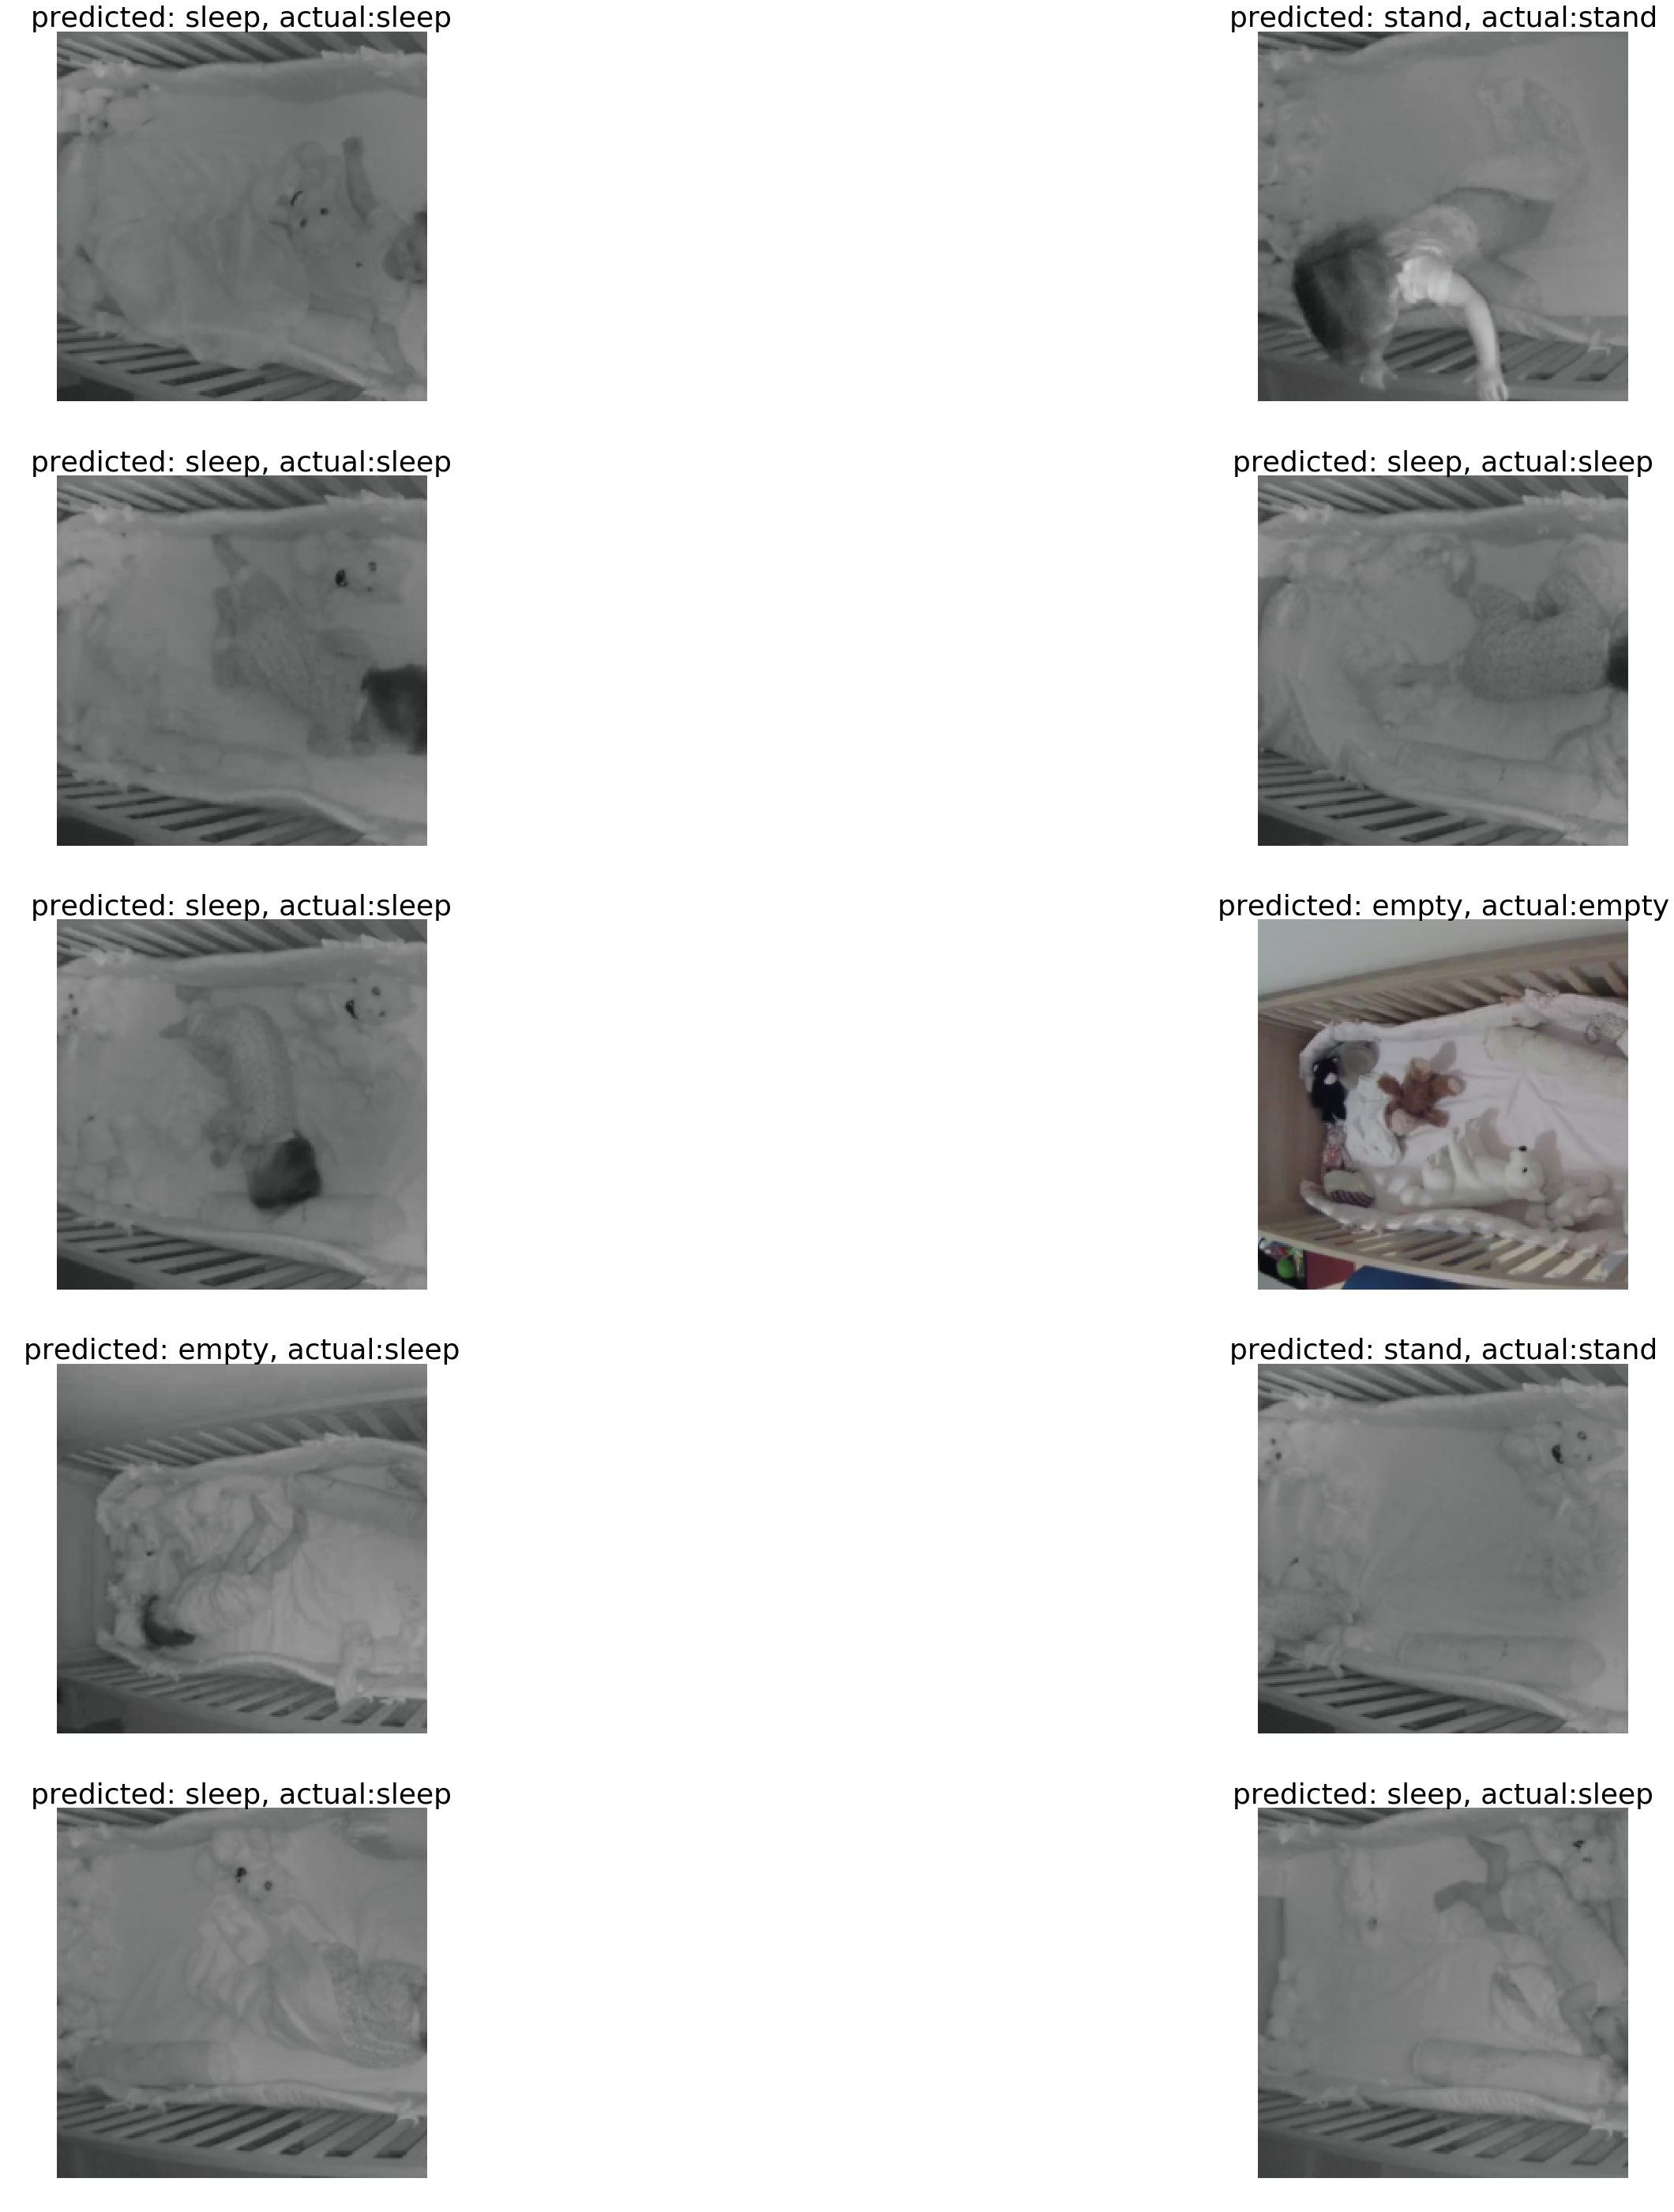

In [36]:
visualize_model(loaded_model2)